<a href="https://colab.research.google.com/github/stanislavfort/multi-attacks/blob/main/multiattack_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-attacks: Many images $+$ the same adversarial attack $\to$ many target labels

This is a Colab replicating the basic results of the Multi-attacks: Many images + the same adversarial attack $\to$ many target labels paper by Stanislav Fort. It should run in on a single GPU.

It generates successfull multi-attacks. Some examples of what you can get:

## A multi-attack

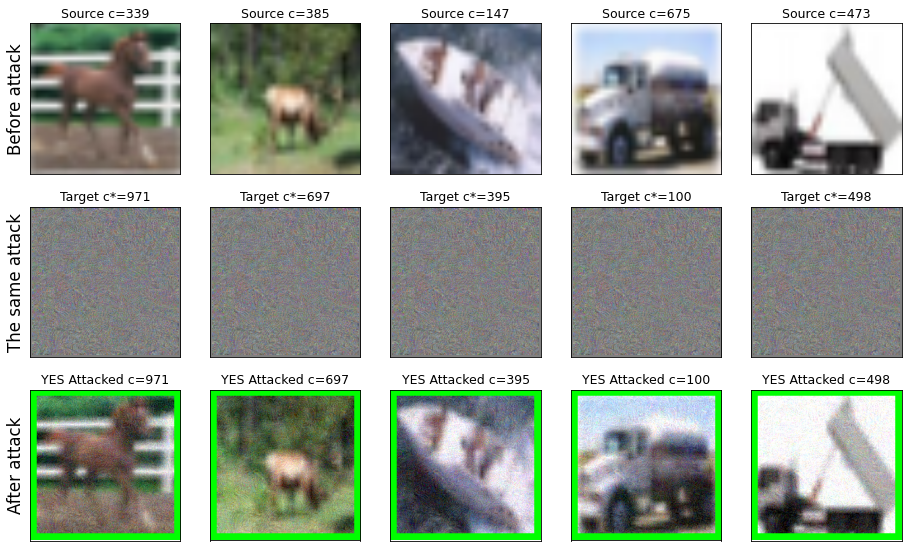

## A 2D section of the pixel space spelling AGI

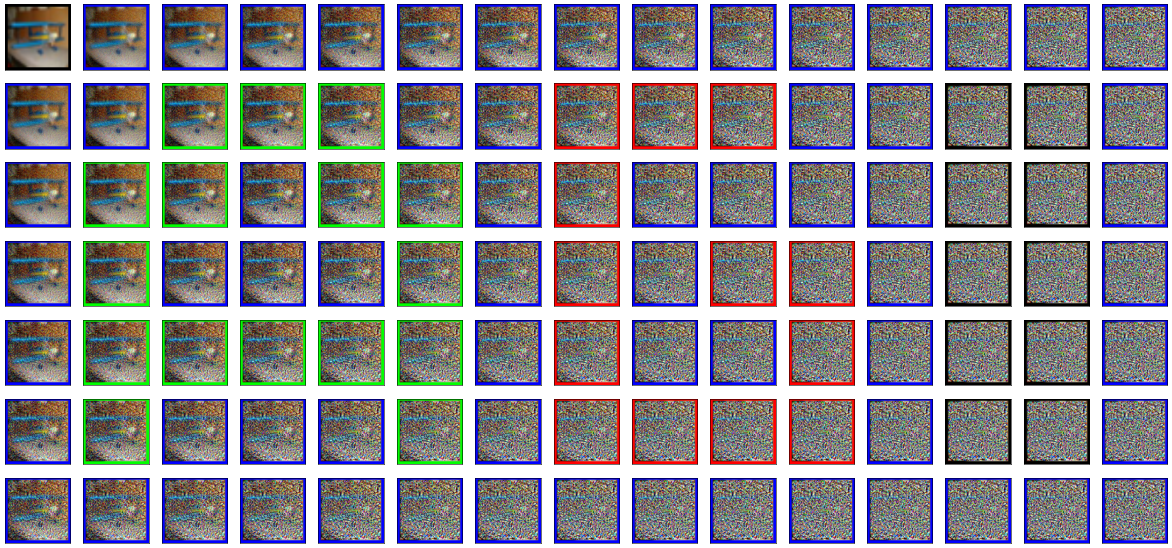

# Imports

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import torchvision

from torchvision import datasets, transforms
from torch.optim import AdamW, Adam, SGD
from torchvision.transforms._presets import ImageClassification
from PIL import Image

# Pretrained ImageNet model

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()
model = resnet50(weights=weights)

# Set model to eval mode
model.eval()
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 53.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Images

## Transforms

In [ ]:
# sizer transform
resize_transform_fn = lambda r: transforms.Compose([
    transforms.Resize((r,r)),
    transforms.ToTensor()
])

## Getting CIFAR-10 (arbitrary)

100%|██████████| 170498071/170498071 [00:13<00:00, 13053519.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


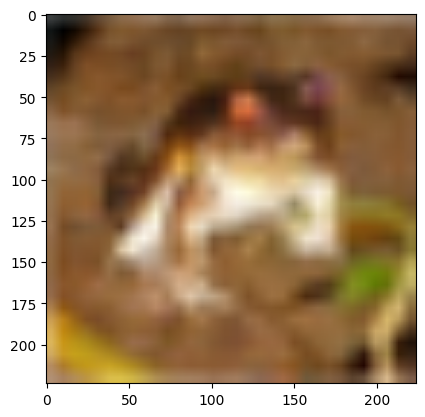

In [ ]:
# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True,
)

images_train_np = trainset.data
labels_train_np = trainset.targets

# trying it out!
plt.imshow(resize_transform_fn(224)(
    Image.fromarray(np.uint8(images_train_np[0]))
).detach().cpu().numpy().transpose([1,2,0]))
plt.show()

# Utils

In [ ]:
def add_linebreaks(text, n):
  lines = [text[i*n:min((i+1)*n,len(text))] for i in range(int(np.ceil(len(text)/n)))]
  new_text = "\n".join(lines)
  return new_text

# Attack loop

In [ ]:
from PIL import Image

def run_attack_experiment(
  batch_size = 32,
  batch_count = 10,
  lr = 1e-1,
  steps = 1000,
  single_attack = False,
  attack_resolution = 32,
  target_labels_value = None,
  use_success_mask_on_loss = False,
  num_classes = 1000,
  override_looks_like_nothing_classes = False, #if False, normal random or specific classes, if True, all classes have equal prob
  do_not_keep_images = True,
  the_same_image_plus_perturbation = None,
  scramble_images=False,
  ):

  #images_to_attack = [resize_transform_fn(attack_resolution)(Image.fromarray(np.uint8(x))) for x in images_train_np[:batch_size*batch_count]]
  images_to_attack = [resize_transform_fn(attack_resolution)(Image.fromarray(np.uint8(x))) for x in images_train_np[np.random.choice(range(len(images_train_np)),(batch_size*batch_count),replace=False)]]
  images_to_attack = torch.stack(images_to_attack,axis=0).to("cuda")

  if the_same_image_plus_perturbation is not None:
    for i in range(len(images_to_attack)):
      noise = torch.Tensor(np.random.normal(loc=0.0,scale=the_same_image_plus_perturbation,size=images_to_attack.shape[1:])).to("cuda")
      images_to_attack[i] = torch.Tensor((images_to_attack[0].clone() + noise.clone()).detach().cpu().numpy()).to("cuda")

  if scramble_images:
    print("🍳 Scrambling image pixels 🍳")
    images_to_attack = torch.Tensor(np.random.permutation(images_to_attack.detach().cpu().numpy())).to("cuda")




  images_to_use = batch_count*batch_size

  # using a single attack vector
  if single_attack:
    image_perturbation = torch.Tensor(np.zeros((1,3,attack_resolution,attack_resolution))).to("cuda")
    print(f"☝ A single attack on all {batch_size*batch_count} images")
  else:
    image_perturbation = torch.Tensor(np.zeros((batch_size*batch_count,3,attack_resolution,attack_resolution))).to("cuda")
    print(f"✋ {batch_size*batch_count} different attacks on {batch_size*batch_count} images")

  image_perturbation.requires_grad = True

  print(f"*** Experiment with {images_to_use} images ***")
  print(f"Attack dimensions = {image_perturbation.shape}")

  if target_labels_value is None:
    target_labels = list(np.random.choice(range(1000), (images_to_use)))
    print(f"🎲 Using random target values")
  else:
    target_labels = [target_labels_value]*images_to_use
    print(f"🎯 Using single target {target_labels_value}")

  # soft labels
  if not override_looks_like_nothing_classes:
    target_labels_hard = torch.Tensor(target_labels).to(torch.long)
    target_labels_soft = torch.nn.functional.one_hot(target_labels_hard, num_classes=1000).to(torch.float).to("cuda")
  else:
    target_labels_soft = torch.Tensor(np.ones((len(target_labels),num_classes))/float(num_classes)).to(torch.float).to("cuda")
    print(f"🤖 Overriding classes to look like nothing. 🤖")

  # print("target_labels_soft",target_labels_soft.shape,target_labels_soft)

  model.eval()
  optimizer = Adam([image_perturbation], lr=lr)

  images_collected = []

  L2_collected = []
  Linfty_collected = []

  success_counts = []

  for step in range(steps):

    successes = []
    success_grid = []

    images_collected_now = []

    for it in range(batch_count):
      i1 = it*batch_size
      i2 = (it+1)*batch_size

      images_to_start = torch.Tensor(images_to_attack[i1:i2]).to("cuda")

      if single_attack:
        logits_out = model(preprocess(images_to_start + image_perturbation))
      else:
        logits_out = model(preprocess(images_to_start + image_perturbation[i1:i2]))

      target_logit_values = logits_out[range(batch_size), target_labels[i1:i2]]

      loss = torch.nn.functional.cross_entropy(logits_out, target_labels_soft[i1:i2],reduction="none")
      losses = loss.clone()

      if use_success_mask_on_loss:
        hit_mask = (argmaxes != torch.Tensor(target_labels[i1:i2]).to("cuda")).to(torch.float)
        loss = loss*hit_mask

      loss = 1.0*torch.mean(loss)

      argmaxes = torch.argmax(logits_out,axis=-1)
      argmaxes_value = torch.max(logits_out,axis=-1)[0]

      if single_attack:
        images_collected_now.append((images_to_start + image_perturbation).detach().cpu().numpy())
      else:
        images_collected_now.append((images_to_start + image_perturbation[i1:i2]).detach().cpu().numpy())

      success = [int(c) for c in argmaxes] == target_labels[i1:i2]

      success_grid = success_grid + [("✅" if int(argmaxes[j]) == target_labels[i1:i2][j] else "❌") for j in range(batch_size)]
      successes.append(success)

      loss.backward()

    images_collected.append(np.concatenate(images_collected_now,axis=0))

    if step % 1 == 0:
      print(f"step={step} hits={success_grid.count('✅')} res={attack_resolution} attack_type={'☝' if single_attack else '✋'} targets={'🎲' if target_labels_value is None else '🎯'} images={'🍳' if scramble_images else '🖼️'}")
      print(add_linebreaks("".join(success_grid),32))

    success_counts.append(success_grid.count('✅'))

    success_str = "✅" if np.sum(successes) == batch_count else "❌"

    L_infty_deviation = torch.max(image_perturbation.reshape([image_perturbation.shape[0],-1]),axis=-1)[0]*255
    L_2_deviation = torch.sqrt(torch.sum(image_perturbation.reshape([image_perturbation.shape[0],-1])**2,axis=-1))*255

    Linfty_collected.append(L_infty_deviation.detach().cpu().numpy())
    L2_collected.append(L_2_deviation.detach().cpu().numpy())

    if np.sum(successes) == batch_count:
      break

    if step % 1 == 0:
      print(f"{success_str} step={step} L_∞={float(torch.max(L_infty_deviation))} loss={loss.item()} target_logits={target_logit_values} argmaxes={argmaxes} at {argmaxes_value} losses {losses}")

    optimizer.step()
    optimizer.zero_grad()

    if do_not_keep_images:
      images_collected = images_collected[0:1] + images_collected[-1:] #only first and last

  if do_not_keep_images:
    return image_perturbation, success_counts, np.stack(Linfty_collected,axis=0), np.stack(L2_collected,axis=0)
  else:
    return target_labels, np.stack(images_collected,axis=0), image_perturbation, success_counts, np.stack(Linfty_collected,axis=0), np.stack(L2_collected,axis=0)



## Single test run -- attacking 100 images at once

In [ ]:
resolutions_to_check = [224]

results = [[] for _ in resolutions_to_check]
Linfty_collected_list = []
L2_collected_list = []

batch_size = 25
batch_count = 4

print(f"Total number of images attacked at once={batch_size*batch_count}")

steps = 300
lr = 1e-2

single_attack = True #if single attack = multi-attack, otherwise standard attack one per image
target_labels_value = None
override_looks_like_nothing_classes = False

do_not_keep_images = False

the_same_image_plus_perturbation = None

scramble_images = False

for j,res in enumerate(resolutions_to_check):
  target_labels, images_collected, image_perturbation, success_counts, Linfty_collected, L2_collected = run_attack_experiment(
    batch_size = batch_size,
    batch_count = batch_count,
    single_attack = single_attack,
    attack_resolution = res,
    target_labels_value = target_labels_value,
    override_looks_like_nothing_classes = override_looks_like_nothing_classes,
    steps = steps,
    lr=lr,
    do_not_keep_images = do_not_keep_images,
    the_same_image_plus_perturbation = the_same_image_plus_perturbation,
    scramble_images=scramble_images,
  )

  results[j].append(success_counts)
  Linfty_collected_list.append(Linfty_collected)
  L2_collected_list.append(L2_collected)

Total number of images attacked at once=100
☝ A single attack on all 100 images
*** Experiment with 100 images ***
Attack dimensions = torch.Size([1, 3, 224, 224])
🎲 Using random target values


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


step=0 hits=1 res=224 attack_type=☝ targets=🎲 images=🖼️
❌❌❌❌❌❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌
❌ step=0 L_∞=0.0 loss=7.793895721435547 target_logits=tensor([-0.6622, -0.0763,  0.3680, -0.2971, -0.7474,  2.9574,  0.1422,  0.2229,
        -0.6072,  0.1674, -0.0435, -1.1252, -0.1601, -0.2908, -0.4252, -1.1077,
         1.5281,  1.1341, -0.4695,  0.0122,  0.1684, -1.3041, -0.6193, -0.1323,
         0.6414], device='cuda:0', grad_fn=<IndexBackward0>) argmaxes=tensor([675, 482, 675, 152,   5, 152, 871, 339, 510,  98, 856, 556, 660, 385,
        365, 278, 294, 901, 284, 675, 675, 914, 274, 331, 103],
       device='cuda:0') at tensor([6.4604, 4.5921, 6.6536, 7.4278, 5.7380, 5.4443, 5.3798, 7.1881, 4.7339,
        5.4918, 5.8094, 4.7461, 6.3636, 5.1218, 6.8364, 5.8024, 5.6980, 4.5867,
        6.0824, 7.0459, 7.8749, 4.9689, 4.7810, 4.1325, 6.5326],
       device='cuda:0', grad_fn=<MaxBackward0>) losses tensor([8.5516, 7.7074, 7.2

## Verifying the results

In [ ]:
def eval_images(images_in,labels_in):

  all_logits = []
  with torch.no_grad():
    for it in range(batch_count):
      # print(f"{it}/{batch_count}")
      i1 = it*batch_size
      i2 = (it+1)*batch_size
      logits_out = model(
        preprocess(torch.Tensor(images_in[i1:i2]).cuda())
      )
      all_logits.append(logits_out)
    all_logits = torch.concatenate(all_logits,axis=0)

  hits = torch.argmax(all_logits,axis=-1).detach().cpu().numpy() == np.array(labels_in)
  # print(f"hits = {np.sum(hits)} / {hits.shape[0]}")

  return np.sum(hits), hits.shape[0], all_logits.detach().cpu().numpy()

In [ ]:
image_perturbation_np = image_perturbation.detach().cpu().numpy()
image_inputs_np_before = images_collected[0]
image_inputs_np_after = images_collected[0] + image_perturbation_np

# before attack
print("Before attack:")
before_corrects, before_total, before_all_logits = eval_images(image_inputs_np_before, target_labels)
success_str = "✅" if before_corrects == before_total else "❌"
print(f"{success_str} hits to target labels = {before_corrects} / {before_total}")

# after attack
print("After attack:")
after_corrects, after_total, after_all_logits = eval_images(image_inputs_np_after, target_labels)
success_str = "✅" if after_corrects == after_total else "❌"
print(f"{success_str} hits to target labels = {after_corrects} / {after_total}")

Before attack:
❌ hits to target labels = 1 / 100
After attack:
✅ hits to target labels = 100 / 100


In [ ]:
def add_border_color(image_array, rim_color=(1,0,0), border_width=10):
  # Create a copy of the image array to preserve the original image data
  image_with_border = np.copy(image_array)

  image_with_border[:border_width, :] = rim_color
  image_with_border[-border_width:, :] = rim_color
  image_with_border[:, :border_width] = rim_color
  image_with_border[:, -border_width:] = rim_color

  return image_with_border

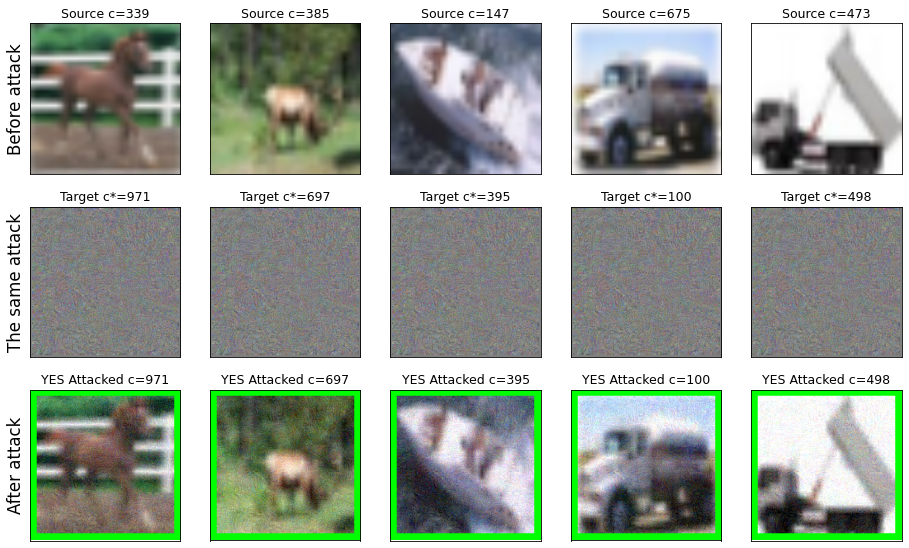

In [ ]:
ids_to_show = range(5)

plt.figure(figsize = (len(ids_to_show)*3,3*3),dpi=75)

for i,j in enumerate(range(len(ids_to_show))):

  plt.subplot(3,len(ids_to_show),i+1)
  label_before = np.argmax(before_all_logits[j])
  plt.title(f"Source c={label_before}")
  if i == 0:
    plt.ylabel("Before attack",fontsize=16)

  plt.imshow((255*image_inputs_np_before[j]).transpose([1,2,0]).astype(np.uint8))
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(3,len(ids_to_show),i+1+1*len(ids_to_show))
  plt.title(f"Target c*={target_labels[j]}")
  if i == 0:
    plt.ylabel("The same attack",fontsize=16)
  plt.imshow(
    (np.clip(image_perturbation_np[0].transpose([1,2,0])*255+128,0,255).astype(np.uint8))
  )
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(3,len(ids_to_show),i+1+2*len(ids_to_show))
  if i == 0:
    plt.ylabel("After attack",fontsize=16)
  label_after = np.argmax(after_all_logits[j])
  if target_labels[j] == label_after:
    plt.title(f"YES Attacked c={label_after}")
    rim_color = (0,255,0)
  else:
    plt.title(f"NO Attacked c={label_after}")
    rim_color = (255,0,0)

  plt.imshow(
      add_border_color(
          (255*(np.clip(image_inputs_np_before[j]+image_perturbation_np[0],0,1))).transpose([1,2,0]).astype(np.uint8),
          rim_color = rim_color
      )
  )
  plt.xticks([],[])
  plt.yticks([],[])


plt.show()

# Experiment 1: The effect of resolution

In [ ]:
resolutions_to_check = [16,32,64,128,224]

results = [[] for _ in resolutions_to_check]
Linfty_collected_list = []
L2_collected_list = []

batch_size = 32
batch_count = 16

print(f"Total number of images attacked at once={batch_size*batch_count}")

steps = 10
lr = 1e-2

single_attack = True #if single attack = multi-attack, otherwise standard attack one per image
target_labels_value = None
override_looks_like_nothing_classes = False

do_not_keep_images = True

the_same_image_plus_perturbation = None

scramble_images = False

for j,res in enumerate(resolutions_to_check):
  image_perturbation, success_counts, Linfty_collected, L2_collected = run_attack_experiment(
    batch_size = batch_size,
    batch_count = batch_count,
    single_attack = single_attack,
    attack_resolution = res,
    target_labels_value = target_labels_value,
    override_looks_like_nothing_classes = override_looks_like_nothing_classes,
    steps = steps,
    lr=lr,
    do_not_keep_images = do_not_keep_images,
    the_same_image_plus_perturbation = the_same_image_plus_perturbation,
    scramble_images=scramble_images,
  )

  results[j].append(success_counts)
  Linfty_collected_list.append(Linfty_collected)
  L2_collected_list.append(L2_collected)

Total number of images attacked at once=512
☝ A single attack on all 512 images
*** Experiment with 512 images ***
Attack dimensions = torch.Size([1, 3, 16, 16])
🎲 Using random target values
step=0 hits=1 res=16 attack_type=☝ targets=🎲 images=🖼️
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌ step=0 L_∞=0.0 loss=7.40846061706543 target_logits=tensor([ 1.4269, -0.7071,  0.5690,  1.7746,  0.4809, -0.4953, -0.2286, -0.2234,
        -0.5057,  0.5170,  1.7056,  0.3858,  2.0978,  3.8917, -0.2230,  1.6400,
        -0.51

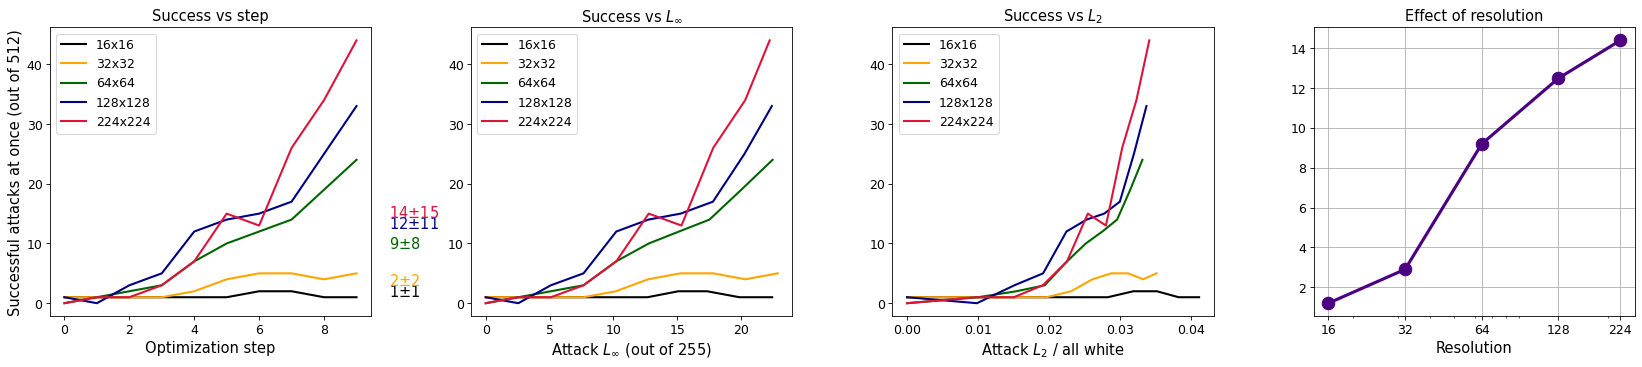

In [ ]:
plt.figure(figsize=(4*5.5,5),dpi=75)

resolutions = []
means = []
errors = []

for j,res in enumerate(resolutions_to_check):

  success_counts = results[j][0]
  Linfty_collected = Linfty_collected_list[j]
  L2_collected = L2_collected_list[j]


  color = {
      "16": "black",
      "32": "orange",
      "64": "darkgreen",
      "128": "navy",
      "224": "crimson",
  }[str(res)]

  label = f"{res}x{res}"

  plt.subplot(1,4,1)
  plt.plot(
      success_counts,
      label=label,
      color=color,
      alpha=1.0,
      linewidth=2,
  )

  mean = np.mean(success_counts[-20:])
  error = np.std(success_counts[-20:])

  resolutions.append(res)
  means.append(mean)
  errors.append(error)

  # if i in [len(single_files)-1,len(single_files)-2]:
  #   x_offset = -140
  #   y_offset = 10
  # else:
  x_offset = -0
  y_offset = -0

  if error < 1.0:
    error = 1.0
  plt.text(len(success_counts)+x_offset,mean+y_offset,f"{int(mean)}$\pm${int(np.ceil(error))}",color=color,fontsize=14)

  plt.subplot(1,4,2)
  plt.plot(
      Linfty_collected[:,0],
      success_counts,
      label=label,
      color=color,
      alpha=1.0,
      linewidth=2,
  )

  plt.subplot(1,4,3)
  plt.plot(
      L2_collected[:,0] / np.sqrt((255**2)*(3*res**2)),
      success_counts,
      label=label,
      color=color,
      alpha=1.0,
      linewidth=2,
  )

plt.subplot(1,4,1)
plt.title("Success vs step",fontsize=14)
plt.xlabel("Optimization step",fontsize=14)
plt.ylabel(f"Successful attacks at once (out of {batch_size*batch_count})",fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,4,2)
plt.title("Success vs $L_\infty$",fontsize=14)
plt.xlabel("Attack $L_\infty$ (out of 255)",fontsize=14)
# plt.ylabel("Successful attacks at once (out of 1024)",fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,4,3)
plt.title("Success vs $L_2$",fontsize=14)
plt.xlabel(f"Attack $L_2$ / all white",fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,4,4)
plt.title("Effect of resolution",fontsize=14)
plt.xlabel(f"Resolution",fontsize=14)
# plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.semilogx(resolutions,means,color="indigo",linewidth=3,marker="o",markersize=12)
plt.xticks(resolutions,resolutions,fontsize=12)

plt.tight_layout()

plt.show()

# Experiment 2: a line of adversaries

In [ ]:
batch_size = 5
batch_count = 1

target_labels = [111,222,333,444,555]

images_to_use = batch_count*batch_size

change_steps = batch_size*batch_count

lr = 1e-2
steps = 1000

attack_resolution = 32

image_id_to_use = 3713

In [ ]:

images_to_use_np = images_train_np[:batch_size*batch_count]
for i in range(len(images_to_use_np)):
  images_to_use_np[i] = np.array(images_train_np[image_id_to_use]) #all of them are the same image

images_to_attack = [resize_transform_fn(attack_resolution)(Image.fromarray(np.uint8(x))) for x in images_to_use_np]
images_to_attack = torch.stack(images_to_attack,axis=0).to("cuda")


image_perturbation = torch.Tensor(np.zeros((1,3,attack_resolution,attack_resolution))).to("cuda")
print(f"☝ A single attack on all {batch_size*batch_count} images")

image_perturbation.requires_grad = True

print(f"*** Experiment with {images_to_use} images ***")
print(f"Attack dimensions = {image_perturbation.shape}")

target_labels_hard = torch.Tensor(target_labels).to(torch.long)
target_labels_soft = torch.nn.functional.one_hot(target_labels_hard, num_classes=1000).to(torch.float).to("cuda")

model.eval()
optimizer = Adam([image_perturbation], lr=lr)

images_collected = []

for step in range(steps):

  successes = []
  success_grid = []

  images_collected_now = []

  for it in range(batch_count):
    i1 = it*batch_size
    i2 = (it+1)*batch_size

    images_to_start = torch.Tensor(images_to_attack[i1:i2]).to("cuda")

    mutliplier = torch.Tensor(np.arange(i1+1,i2+1)).reshape([i2-i1,1,1,1]).to("cuda")

    logits_out = model(preprocess(images_to_start + mutliplier*image_perturbation))

    target_logit_values = logits_out[range(batch_size), target_labels[i1:i2]]

    loss = torch.nn.functional.cross_entropy(logits_out, target_labels_soft[i1:i2],reduction="none")
    losses = loss.clone()

    loss = 1.0*torch.mean(loss)

    argmaxes = torch.argmax(logits_out,axis=-1)
    argmaxes_value = torch.max(logits_out,axis=-1)[0]

    images_collected_now.append((images_to_start + mutliplier*image_perturbation).detach().cpu().numpy())

    success = [int(c) for c in argmaxes] == target_labels[i1:i2]

    success_grid = success_grid + [("✅" if int(argmaxes[j]) == target_labels[i1:i2][j] else "❌") for j in range(batch_size)]
    successes.append(success)

    loss.backward()

  images_collected.append(np.concatenate(images_collected_now,axis=0))

  if step % 1 == 0:
    print(f"hits={success_grid.count('✅')}")
    print(add_linebreaks("".join(success_grid),32))

  success_str = "✅" if np.sum(successes) == batch_count else "❌"

  if np.sum(successes) == batch_count:
    break

  L_infty_deviation = torch.max(image_perturbation)*255

  if step % 1 == 0:
    print(f"{success_str} step={step} L_∞={float(L_infty_deviation)} target_logits={target_logit_values} argmaxes={argmaxes} at {argmaxes_value}")

  optimizer.step()
  optimizer.zero_grad()

☝ A single attack on all 5 images
*** Experiment with 5 images ***
Attack dimensions = torch.Size([1, 3, 32, 32])
hits=0
❌❌❌❌❌
❌ step=0 L_∞=0.0 target_logits=tensor([ 0.1348, -0.5480, -0.1934, -0.3907, -0.0989], device='cuda:0',
       grad_fn=<IndexBackward0>) argmaxes=tensor([364, 364, 364, 364, 364], device='cuda:0') at tensor([5.2477, 5.2477, 5.2477, 5.2477, 5.2477], device='cuda:0',
       grad_fn=<MaxBackward0>)
hits=0
❌❌❌❌❌
❌ step=1 L_∞=2.5500001907348633 target_logits=tensor([ 0.6874, -0.3128, -0.4147, -0.2236, -0.6873], device='cuda:0',
       grad_fn=<IndexBackward0>) argmaxes=tensor([21, 21, 21, 21, 21], device='cuda:0') at tensor([4.7850, 5.1867, 5.2014, 5.1986, 5.0238], device='cuda:0',
       grad_fn=<MaxBackward0>)
hits=0
❌❌❌❌❌
❌ step=2 L_∞=5.103462219238281 target_logits=tensor([ 0.8771, -0.0990, -0.0867, -0.2657, -0.4000], device='cuda:0',
       grad_fn=<IndexBackward0>) argmaxes=tensor([404, 404, 404, 404, 149], device='cuda:0') at tensor([4.9749, 5.5159, 5.7796, 5.3

In [ ]:
images_collected_np = np.stack(images_collected,axis=0)

starting_class = int(torch.argmax(model(
  preprocess(torch.Tensor(images_collected_np[0][:1]).cuda())
)))

all_logits = []
with torch.no_grad():
  for it in range(batch_count):
    print(f"{it}/{batch_count}")
    i1 = it*batch_size
    i2 = (it+1)*batch_size
    logits_out = model(
      preprocess(torch.Tensor(images_collected_np[-1][i1:i2]).cuda())
    )
    all_logits.append(logits_out)
  all_logits = torch.concatenate(all_logits,axis=0)

0/1


In [ ]:
predicted_classes = torch.argmax(all_logits,axis=-1)

In [ ]:
print(f"classes predicted = {predicted_classes.detach().cpu().numpy()}")
print(f"classes target = {target_labels}")

classes predicted = [111 222 333 444 555]
classes target = [111, 222, 333, 444, 555]


## Visualization

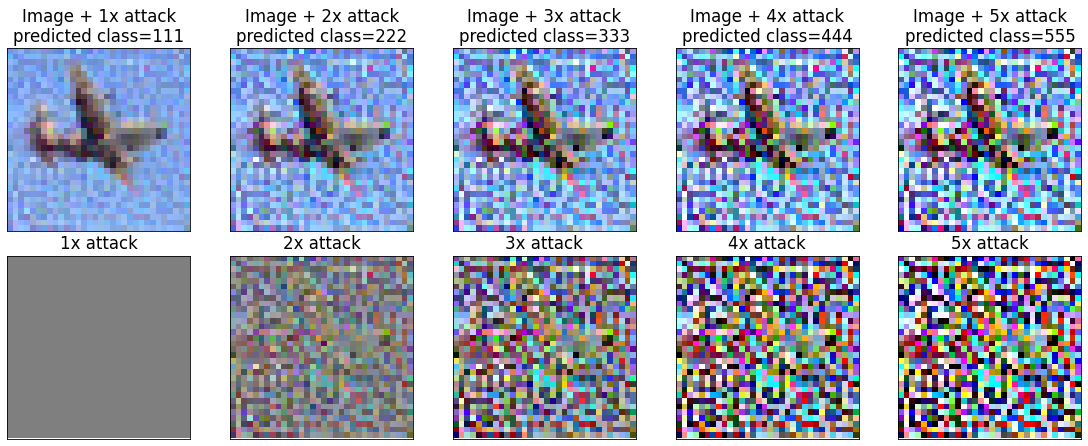

In [ ]:
selected_ids = [0,1,2,3,4]

plt.figure(figsize=(3*len(selected_ids),2*3),dpi=75)

for i,j in enumerate(selected_ids):
  plt.subplot(2,len(selected_ids),i+1)
  plt.title(f"Image + {j+1}x attack\npredicted class={predicted_classes[j]}",fontsize=16)
  plt.imshow(
      (np.clip(images_collected_np[-1][j].transpose([1,2,0]),0,1)*255).astype(np.uint8)
  )
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(2,len(selected_ids),i+1+len(selected_ids))
  plt.title(f"{j+1}x attack",fontsize=16)
  plt.imshow(
      # images_collected_np[-1][i].transpose([1,2,0])
      np.clip((j+i)*image_perturbation.detach().cpu().numpy()[0].transpose([1,2,0])+0.5,0,1)
  )
  plt.xticks([],[])
  plt.yticks([],[])

plt.tight_layout()
plt.show()

In [ ]:
logits_to_check = {
    starting_class: [],
    111: [],
    222: [],
    333: [],
    444: [],
    555: [],
}

argmaxes = []

ts = np.linspace(0.0,9.0,300)

with torch.no_grad():
  for t in ts:
    # print(t)
    logits_out = model(preprocess(images_to_start + t*image_perturbation))
    probs_out = torch.nn.Softmax(-1)(logits_out).detach().cpu().numpy()
    argmaxes.append(int(np.argmax(probs_out[0])))
    for key in logits_to_check.keys():
      logits_to_check[key].append(probs_out[0,key])


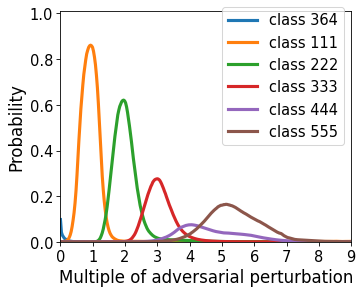

In [ ]:
plt.figure(figsize=(5,4),dpi=75)

for key in logits_to_check.keys():
  # if key == 111:
  #   color = "crimson"
  if key == 510:
    color = "black"
    linewidth = 4.0
  else:
    line, = plt.plot([],[])
    color = line.get_color()
    linewidth = 3.0

  plt.plot(ts,logits_to_check[key],label=f"class {key}",color=color,linewidth=linewidth)

plt.ylabel("Probability",fontsize=16)
plt.xlabel("Multiple of adversarial perturbation",fontsize=16)
plt.ylim([0.0,1.01])
plt.xlim([0,np.max(ts)])
plt.legend(loc="upper right")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.grid()

plt.gca().legend(bbox_to_anchor=(1.0, 1.05),fontsize=14)

plt.show()

# Experiment 3: scale-independent attack

In [ ]:
batch_size = 5
batch_count = 1
images_to_use = batch_count*batch_size

target_labels = [111]*images_to_use

change_steps = batch_size*batch_count

lr = 1e-2
steps = 1000

attack_resolution = 32

image_id_to_use = 3713

In [ ]:
images_to_use_np = images_train_np[:batch_size*batch_count]
for i in range(len(images_to_use_np)):
  images_to_use_np[i] = np.array(images_train_np[image_id_to_use]) #all of them are the same image

images_to_attack = [resize_transform_fn(attack_resolution)(Image.fromarray(np.uint8(x))) for x in images_to_use_np]
images_to_attack = torch.stack(images_to_attack,axis=0).to("cuda")


image_perturbation = torch.Tensor(np.zeros((1,3,attack_resolution,attack_resolution))).to("cuda")
print(f"☝ A single attack on all {batch_size*batch_count} images")

image_perturbation.requires_grad = True

print(f"*** Experiment with {images_to_use} images ***")
print(f"Attack dimensions = {image_perturbation.shape}")

target_labels_hard = torch.Tensor(target_labels).to(torch.long)
target_labels_soft = torch.nn.functional.one_hot(target_labels_hard, num_classes=1000).to(torch.float).to("cuda")

model.eval()
optimizer = Adam([image_perturbation], lr=lr)

images_collected = []

for step in range(steps):

  successes = []
  success_grid = []

  images_collected_now = []

  for it in range(batch_count):
    i1 = it*batch_size
    i2 = (it+1)*batch_size

    images_to_start = torch.Tensor(images_to_attack[i1:i2]).to("cuda")

    mutliplier = torch.Tensor(np.arange(i1+1,i2+1)).reshape([i2-i1,1,1,1]).to("cuda")

    logits_out = model(preprocess(images_to_start + mutliplier*image_perturbation))

    target_logit_values = logits_out[range(batch_size), target_labels[i1:i2]]

    loss = torch.nn.functional.cross_entropy(logits_out, target_labels_soft[i1:i2],reduction="none")
    losses = loss.clone()

    loss = 1.0*torch.mean(loss)

    argmaxes = torch.argmax(logits_out,axis=-1)
    argmaxes_value = torch.max(logits_out,axis=-1)[0]

    images_collected_now.append((images_to_start + mutliplier*image_perturbation).detach().cpu().numpy())

    success = [int(c) for c in argmaxes] == target_labels[i1:i2]

    success_grid = success_grid + [("✅" if int(argmaxes[j]) == target_labels[i1:i2][j] else "❌") for j in range(batch_size)]
    successes.append(success)

    loss.backward()

  images_collected.append(np.concatenate(images_collected_now,axis=0))

  if step % 1 == 0:
    print(f"hits={success_grid.count('✅')}")
    print(add_linebreaks("".join(success_grid),32))

  success_str = "✅" if np.sum(successes) == batch_count else "❌"

  if np.sum(successes) == batch_count:
    break

  L_infty_deviation = torch.max(image_perturbation)*255

  if step % 1 == 0:
    print(f"{success_str} step={step} L_∞={float(L_infty_deviation)} target_logits={target_logit_values} argmaxes={argmaxes} at {argmaxes_value}")

  optimizer.step()
  optimizer.zero_grad()

☝ A single attack on all 5 images
*** Experiment with 5 images ***
Attack dimensions = torch.Size([1, 3, 32, 32])
hits=0
❌❌❌❌❌
❌ step=0 L_∞=0.0 target_logits=tensor([0.1348, 0.1348, 0.1348, 0.1348, 0.1348], device='cuda:0',
       grad_fn=<IndexBackward0>) argmaxes=tensor([364, 364, 364, 364, 364], device='cuda:0') at tensor([5.2477, 5.2477, 5.2477, 5.2477, 5.2477], device='cuda:0',
       grad_fn=<MaxBackward0>)
hits=1
❌❌❌❌✅
❌ step=1 L_∞=2.5500001907348633 target_logits=tensor([2.4498, 3.5802, 4.2754, 4.6114, 4.9646], device='cuda:0',
       grad_fn=<IndexBackward0>) argmaxes=tensor([404,  21,  21, 327, 111], device='cuda:0') at tensor([5.1202, 5.3135, 4.8036, 4.6695, 4.9646], device='cuda:0',
       grad_fn=<MaxBackward0>)
hits=5
✅✅✅✅✅


In [ ]:
images_collected_np = np.stack(images_collected,axis=0)

all_logits = []
with torch.no_grad():
  for it in range(batch_count):
    print(f"{it}/{batch_count}")
    i1 = it*batch_size
    i2 = (it+1)*batch_size
    logits_out = model(
      preprocess(torch.Tensor(images_collected_np[-1][i1:i2]).cuda())
    )
    all_logits.append(logits_out)
  all_logits = torch.concatenate(all_logits,axis=0)

0/1


In [ ]:
predicted_classes = torch.argmax(all_logits,axis=-1)

In [ ]:
print(f"classes predicted = {predicted_classes.detach().cpu().numpy()}")
print(f"classes target = {target_labels}")

classes predicted = [111 111 111 111 111]
classes target = [111, 111, 111, 111, 111]


## Visualization

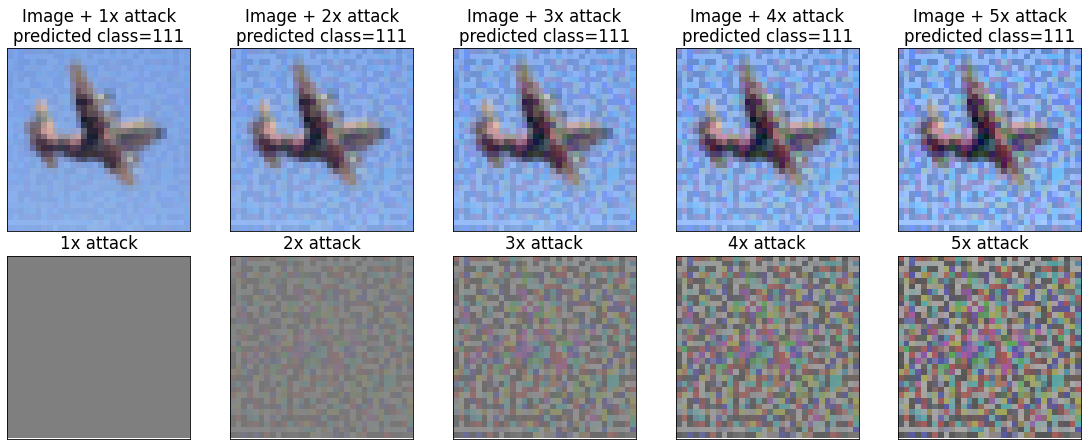

In [ ]:
selected_ids = [0,1,2,3,4]

plt.figure(figsize=(3*len(selected_ids),2*3),dpi=75)

for i,j in enumerate(selected_ids):
  plt.subplot(2,len(selected_ids),i+1)
  plt.title(f"Image + {j+1}x attack\npredicted class={predicted_classes[j]}",fontsize=16)
  plt.imshow(
      (np.clip(images_collected_np[-1][j].transpose([1,2,0]),0,1)*255).astype(np.uint8)
  )
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(2,len(selected_ids),i+1+len(selected_ids))
  plt.title(f"{j+1}x attack",fontsize=16)
  plt.imshow(
      # images_collected_np[-1][i].transpose([1,2,0])
      np.clip((j+i)*image_perturbation.detach().cpu().numpy()[0].transpose([1,2,0])+0.5,0,1)
  )
  plt.xticks([],[])
  plt.yticks([],[])

plt.tight_layout()
plt.show()

In [ ]:
logits_to_check = {
    starting_class: [],
    target_labels[0]: [],
}

argmaxes = []

ts = np.linspace(0.0,9.0,300)

with torch.no_grad():
  for t in ts:
    # print(t)
    logits_out = model(preprocess(images_to_start + t*image_perturbation))
    probs_out = torch.nn.Softmax(-1)(logits_out).detach().cpu().numpy()
    argmaxes.append(int(np.argmax(probs_out[0])))
    for key in logits_to_check.keys():
      logits_to_check[key].append(probs_out[0,key])


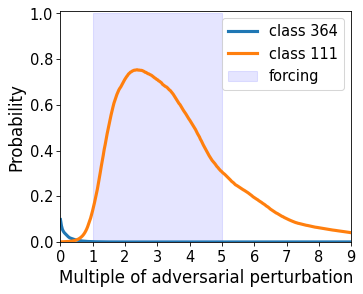

In [ ]:
plt.figure(figsize=(5,4),dpi=75)

for key in logits_to_check.keys():
  linewidth = 3.0
  plt.plot(ts,logits_to_check[key],label=f"class {key}",linewidth=linewidth)

plt.fill_between([1,change_steps],[0,0],[1,1],color="blue",alpha=0.1,label="forcing")

plt.ylabel("Probability",fontsize=16)
plt.xlabel("Multiple of adversarial perturbation",fontsize=16)
plt.ylim([0.0,1.01])
plt.xlim([0,np.max(ts)])
plt.legend(loc="upper right")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.grid()

plt.gca().legend(fontsize=14)

plt.show()

# Experiment 4: looking for images

the picture is a just a 2D slice of the input space. So it is defined by two perturbations, $P_x$ and $P_y$, and the picture is filled by $\alpha P_x$ and $\beta P_y$, and the $\alpha$ and $\beta$ can even be integers. Let's try it.

In [ ]:
image_classes = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,4,4,4,0,0,2,2,2,0,0,3,3,0],
    [0,4,4,0,4,4,0,2,0,0,0,0,3,3,0],
    [0,4,0,0,0,4,0,2,0,2,2,0,3,3,0],
    [0,4,4,4,4,4,0,2,0,0,2,0,3,3,0],
    [0,4,0,0,0,4,0,2,2,2,2,0,3,3,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])


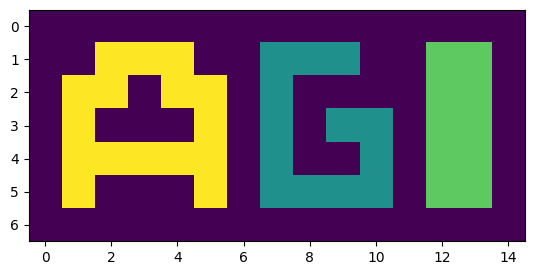

In [ ]:
image_classes = np.array(image_classes[:])

y_multiples = []
x_multiples = []
for i in range(image_classes.shape[0]):
  for j in range(image_classes.shape[1]):
    y_multiples.append(i)
    x_multiples.append(j)

plt.imshow(image_classes)
plt.show()

In [ ]:
image_classes[image_classes==0] = 111
image_classes[image_classes==4] = 222
image_classes[image_classes==2] = 333
image_classes[image_classes==3] = 444

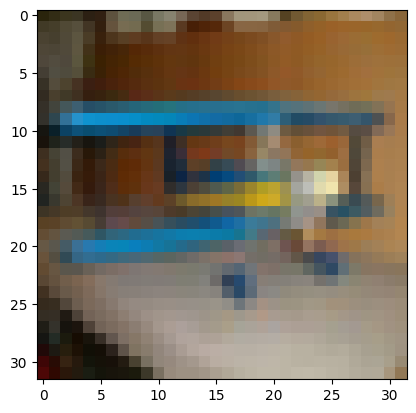

In [ ]:
i_chosen_image = 25350
plt.imshow(images_train_np[i_chosen_image])
plt.show()

In [ ]:
image_to_start = resize_transform_fn(attack_resolution)(Image.fromarray(np.uint8(images_train_np[i_chosen_image])))
image_to_start = torch.stack([image_to_start],axis=0).to("cuda")

orig_class = torch.argmax(model(preprocess(image_to_start.to("cuda"))))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
image_classes[0][0] = int(orig_class)

In [ ]:
lr = 1e-2
steps = 1000
single_attack = True

batch_count = image_classes.shape[0]
batch_size = image_classes.shape[1]

attack_resolution = 224
use_success_mask_on_loss = False

images_to_use = int(image_classes.shape[0] * image_classes.shape[1])

images_to_use_np = images_train_np[:images_to_use] #to get the right size
for i in range(len(images_to_use_np)):
  images_to_use_np[i] = np.array(images_train_np[i_chosen_image]) #all of them are the same image


images_to_attack = [resize_transform_fn(attack_resolution)(Image.fromarray(np.uint8(x))) for x in images_to_use_np]
images_to_attack = torch.stack(images_to_attack,axis=0).to("cuda")


x_image_perturbation = torch.Tensor(np.zeros((1,3,attack_resolution,attack_resolution))).to("cuda")
y_image_perturbation = torch.Tensor(np.zeros((1,3,attack_resolution,attack_resolution))).to("cuda")

x_image_perturbation.requires_grad = True
y_image_perturbation.requires_grad = True

print(f"*** Experiment with {images_to_use} images ***")
print(f"X Attack dimensions = {x_image_perturbation.shape}")
print(f"Y Attack dimensions = {y_image_perturbation.shape}")

target_labels = list(image_classes.reshape([-1]))

target_labels_hard = torch.Tensor(target_labels).to(torch.long)
target_labels_soft = torch.nn.functional.one_hot(target_labels_hard, num_classes=1000).to(torch.float).to("cuda")

model.eval()
optimizer = Adam([x_image_perturbation, y_image_perturbation], lr=lr)

images_collected = []

for step in range(steps):

  successes = []
  success_grid = []

  images_collected_now = []

  for it in range(batch_count):
    i1 = it*batch_size
    i2 = (it+1)*batch_size

    images_to_start = torch.Tensor(images_to_attack[i1:i2]).to("cuda")

    x_mutliplier = torch.Tensor(x_multiples[i1:i2]).reshape([i2-i1,1,1,1]).to("cuda")
    y_mutliplier = torch.Tensor(y_multiples[i1:i2]).reshape([i2-i1,1,1,1]).to("cuda")

    logits_out = model(preprocess(images_to_start + x_mutliplier*x_image_perturbation + y_mutliplier*y_image_perturbation))

    logit_means = torch.mean(logits_out,axis=-1)
    target_logit_values = logits_out[range(batch_size), target_labels[i1:i2]]

    loss = torch.nn.functional.cross_entropy(logits_out, target_labels_soft[i1:i2],reduction="none")
    losses = loss.clone()

    argmaxes = torch.argmax(logits_out,axis=-1)
    argmaxes_value = torch.max(logits_out,axis=-1)[0]

    if use_success_mask_on_loss:
      hit_mask = (argmaxes != torch.Tensor(target_labels[i1:i2]).to("cuda")).to(torch.float)
      loss = loss*hit_mask

    loss = 1.0*torch.mean(loss)

    # loss = target_logit_values - logit_means

    # loss = -1.0*torch.mean(loss)


    images_collected_now.append((images_to_start + x_mutliplier*x_image_perturbation + y_mutliplier*y_image_perturbation).detach().cpu().numpy())
    success = [int(c) for c in argmaxes] == target_labels[i1:i2]

    success_grid = success_grid + [("✅" if int(argmaxes[j]) == target_labels[i1:i2][j] else "❌") for j in range(batch_size)]
    successes.append(success)

    loss.backward()

  images_collected.append(np.concatenate(images_collected_now,axis=0))

  if step % 1 == 0:
    print(f"hits={success_grid.count('✅')}")
    print(add_linebreaks("".join(success_grid),32))

  success_str = "✅" if np.sum(successes) == batch_count else "❌"

  if np.sum(successes) == batch_count:
    break

  L_infty_deviation = torch.max(torch.Tensor([torch.max(x_image_perturbation)*255,torch.max(y_image_perturbation)*255]))

  if step % 1 == 0:
    print(f"{success_str} step={step} L_∞={float(L_infty_deviation)} target_logits={target_logit_values} argmaxes={argmaxes} at {argmaxes_value}")

  optimizer.step()
  optimizer.zero_grad()

*** Experiment with 105 images ***
X Attack dimensions = torch.Size([1, 3, 224, 224])
Y Attack dimensions = torch.Size([1, 3, 224, 224])
hits=1
✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌
❌ step=0 L_∞=0.0 target_logits=tensor([-0.0245, -0.0245, -0.0245, -0.0245, -0.0245, -0.0245, -0.0245, -0.0245,
        -0.0245, -0.0245, -0.0245, -0.0245, -0.0245, -0.0245, -0.0245],
       device='cuda:0', grad_fn=<IndexBackward0>) argmaxes=tensor([729, 729, 729, 729, 729, 729, 729, 729, 729, 729, 729, 729, 729, 729,
        729], device='cuda:0') at tensor([5.8313, 5.8313, 5.8313, 5.8313, 5.8313, 5.8313, 5.8313, 5.8313, 5.8313,
        5.8313, 5.8313, 5.8313, 5.8313, 5.8313, 5.8313], device='cuda:0',
       grad_fn=<MaxBackward0>)
hits=1
✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌
❌ step=1 L_∞=2.5500001907348633 target_logits=tensor([0.5491, 0.7548, 0.9275, 1.0927, 1.1694

In [ ]:
images_collected_np = np.stack(images_collected,axis=0)

In [ ]:
images_to_predict_on = images_collected[-1]

all_logits_collected = []

with torch.no_grad():

  for it in range(batch_count):
    i1 = it*batch_size
    i2 = (it+1)*batch_size

    images_to_start = torch.Tensor(images_to_predict_on[i1:i2]).to("cuda")
    logits_out = model(preprocess(images_to_start))
    all_logits_collected.append(logits_out.detach().cpu().numpy())

In [ ]:
all_logits_collected_np = np.array(all_logits_collected)

In [ ]:
final_argmaxes = np.argmax(all_logits_collected_np,axis=-1)

In [ ]:
image_to_start = torch.Tensor(images_collected[0][:1]).to("cuda")

all_logits_collected = []

ts_y = np.linspace(-1,image_classes.shape[0],40)
ts_x = np.linspace(-1,image_classes.shape[1],40)

logits_grid = np.zeros((len(ts_y),len(ts_x),1000))
probs_grid = np.zeros((len(ts_y),len(ts_x),1000))

with torch.no_grad():

  for i_x,t_x in enumerate(ts_x):
    for i_y,t_y in enumerate(ts_y):

      x_mutliplier = torch.Tensor([t_x]).reshape([1,1,1,1]).to("cuda")
      y_mutliplier = torch.Tensor([t_y]).reshape([1,1,1,1]).to("cuda")

      logits_out = model(preprocess(image_to_start + x_mutliplier*x_image_perturbation + y_mutliplier*y_image_perturbation))

      logits_grid[i_y,i_x] = logits_out.detach().cpu().numpy()[0]
      probs_grid[i_y,i_x] = torch.nn.Softmax(-1)(logits_out).detach().cpu().numpy()[0]

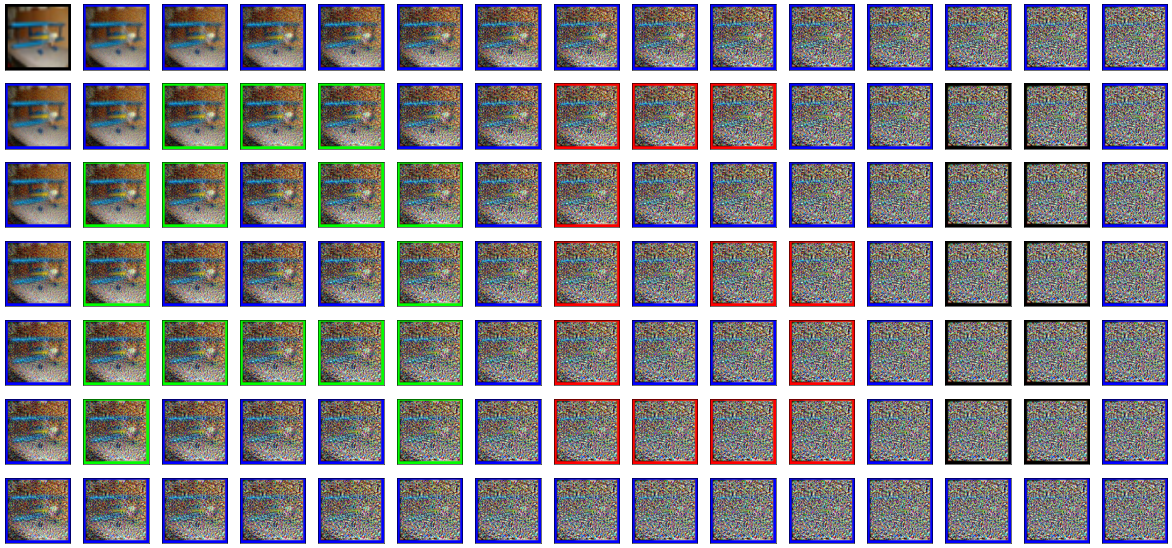

In [ ]:
# grid of images
plt.figure(
    figsize = (image_classes.shape[1]*2,image_classes.shape[0]*2),
    dpi=50
)

for i in range(len(images_collected[-1])):
  plt.subplot(image_classes.shape[0],image_classes.shape[1],i+1)
  data = np.clip(images_collected[-1][i].transpose([1,2,0])*255,0,255).astype(np.uint8)
  height, width, _ = data.shape


  if final_argmaxes.reshape([-1])[i] == 111:
    frame_color = [0, 0, 255]  # Red color (RGB format)
  elif final_argmaxes.reshape([-1])[i] == 222:
    frame_color = [0, 255, 0]  # Red color (RGB format)
  elif final_argmaxes.reshape([-1])[i] == 333:
    frame_color = [255, 0, 0]  # Red color (RGB format)
  else:
    frame_color = [0, 0, 0]  # Red color (RGB format)


  frame_width = 10  # Adjust the width of the frame as needed
  framed_image = np.ones((height + frame_width*2, width + frame_width*2, 3), dtype=np.uint8) * frame_color
  framed_image[frame_width:-frame_width, frame_width:-frame_width] = data
  plt.imshow(framed_image)
  plt.xticks([],[])
  plt.yticks([],[])
plt.show()